Copyright (c) 2015 - 2017 [Sebastian Raschka](sebastianraschka.com)

https://github.com/rasbt/python-machine-learning-book

[MIT License](https://github.com/rasbt/python-machine-learning-book/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 3 - A Tour of Machine Learning Classifiers Using Scikit-Learn

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -p numpy,pandas,matplotlib,sklearn

ModuleNotFoundError: No module named 'watermark'

*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

### Overview

- [Choosing a classification algorithm](#Choosing-a-classification-algorithm)
- [First steps with scikit-learn](#First-steps-with-scikit-learn)
    - [Training a perceptron via scikit-learn](#Training-a-perceptron-via-scikit-learn)
- [Modeling class probabilities via logistic regression](#Modeling-class-probabilities-via-logistic-regression)
    - [Logistic regression intuition and conditional probabilities](#Logistic-regression-intuition-and-conditional-probabilities)
    - [Learning the weights of the logistic cost function](#Learning-the-weights-of-the-logistic-cost-function)
    - [Training a logistic regression model with scikit-learn](#Training-a-logistic-regression-model-with-scikit-learn)
    - [Tackling overfitting via regularization](#Tackling-overfitting-via-regularization)
- [Maximum margin classification with support vector machines](#Maximum-margin-classification-with-support-vector-machines)
    - [Maximum margin intuition](#Maximum-margin-intuition)
    - [Dealing with the nonlinearly separable case using slack variables](#Dealing-with-the-nonlinearly-separable-case-using-slack-variables)
    - [Alternative implementations in scikit-learn](#Alternative-implementations-in-scikit-learn)
- [Solving nonlinear problems using a kernel SVM](#Solving-nonlinear-problems-using-a-kernel-SVM)
    - [Using the kernel trick to find separating hyperplanes in higher dimensional space](#Using-the-kernel-trick-to-find-separating-hyperplanes-in-higher-dimensional-space)
- [Decision tree learning](#Decision-tree-learning)
    - [Maximizing information gain – getting the most bang for the buck](#Maximizing-information-gain-–-getting-the-most-bang-for-the-buck)
    - [Building a decision tree](#Building-a-decision-tree)
    - [Combining weak to strong learners via random forests](#Combining-weak-to-strong-learners-via-random-forests)
- [K-nearest neighbors – a lazy learning algorithm](#K-nearest-neighbors-–-a-lazy-learning-algorithm)
- [Summary](#Summary)

<br>
<br>

<br>
<br>

In [2]:
from IPython.display import Image
%matplotlib inline

In [3]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

# Choosing a classification algorithm

...

# First steps with scikit-learn

Loading the Iris dataset from scikit-learn. Here, the third column represents the petal length, and the fourth column the petal width of the flower samples. The classes are already converted to integer labels where 0=Iris-Setosa, 1=Iris-Versicolor, 2=Iris-Virginica.

In [4]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

# 印出有幾種 y 的類型
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


Splitting data into 70% training and 30% test data:

In [5]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

    
# 切割資料為訓練與測試集, 切出0.3 為測試資料
# 新版的要用sklearn.model_selection
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

Standardizing the features:

In [6]:
# 將特徵標準化
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

# 以X_train計算出標準化基準(一般應該要用整個X來計算？)
sc.fit(X_train)

# 標準化 train 與 test
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

<br>
<br>

## Training a perceptron via scikit-learn

Redefining the `plot_decision_region` function from chapter 2:

In [7]:
from sklearn.linear_model import Perceptron

# 進行訓練, n_iter 為迭代次數， eta0 為 學習速率, random_state 為每輪都要攪亂
ppn = Perceptron(n_iter=40, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      n_iter=40, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [ ]:
# 確認 y_test 的行列數
y_test.shape

In [ ]:
# 嘗試進行預測，發現在45個 test data中，有4個錯誤
y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())

In [ ]:
from sklearn.metrics import accuracy_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

In [8]:
# 導入繪圖色彩庫產生內置顏色
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings


def versiontuple(v):
    # map 對陣列的每一個元素進行處理，以下方為例則將每一個元素轉為 int
    # 最外層轉換為 tuple type
    return tuple(map(int, (v.split("."))))


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    # x1_min = x 第 0 列取 min() 後 -1, x1_max = x 第 0 列 取 max() 後 +1
    # X[:,k] 冒号左边表示行范围，读取所有行，冒号右边表示列范围，读取第K列
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # arange([start,] stop[, step,], dtype=None)根据start与stop指定的范围以及step设定的步长，生成一个 ndarray
    # meshgrid 根据给定的坐标向量创建坐标矩阵, 實際如下個區塊測試。
    # arange(start,end,step) 返回一个一维数组
    # meshgrid(x,y)产生一个以x为行，y为列的矩阵
    # xx1是一个(305*235)大小的矩阵 xx1.ravel()是将所有的行放在一个行里面的长度71675的一维数组
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    # revel() 將 array 扁平化, np.array().T 創建 array後進行轉置, 用法請見下個區塊
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # resharp(), 將 list 轉換成指定的行列數量, e.g. b = [1, 2, 3, 4, 5, 6] c = b.resharp(2, 3) c = ([1, 2, 3], [4, 5, 6])
    # xx1.shape = (305,205) 将Z重新调整为(305,205)的格式
    Z = Z.reshape(xx1.shape)
    # plt.contourf 把颜色加进去，位置参数分别为：xx1, xx2, z。透明度0.4，并将 z 的值对应到 cmap 中寻找对应颜色，形成底圖顏色
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    # 設定座標軸範圍
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # print(y)
    # print(X[:5,])
    # enumerate() 取得 list 的內容與索引值
    # 畫出所有資料點
    for idx, cl in enumerate(np.unique(y)):
        # print(str(idx) + '=>' + str(cl))
        # X 中帶有 x, y 軸座標, 使用 numpy array 特性，藉由判斷式找到 y == cl 資料的 index 值對應找到所有符合條件的 X 資料
        # print(X[y == cl][:5,])
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

    # highlight test samples
    # 將 test 的資料點 highlight 起來
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    edgecolor='black',
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

meshgrid 產生 array
參考 http://blog.sina.com.cn/s/blog_4c8ff8950100chmc.html

revel 將 array 扁平化

In [ ]:
#meshgrid
a = [1, 2, 3]
b = [4, 5]
A, B = np.meshgrid(a, b)
# a 的資料將以 x 軸開始填充
print('--- meshgrid ---')
print(A)
# b 的資料將以 y 軸開始填充
print(B)
# 兩個矩陣的行列數均相同

#revel
print('--- revel ---')
A_ravel = A.ravel()
print(A_ravel)
B_ravel = B.ravel()
print(B_ravel)

#合成矩陣
print('--- 合成矩陣 ---')
print(np.array([A_ravel, B_ravel]))
print('--- 將其轉置 ---')
print(np.array([A_ravel, B_ravel]).T)

In [ ]:
# numpy 可以讓兩個 index 數量相同的 array , 直接判斷 y 符合條件的 index，並直接拉出 X 中其對應 index 的資料
# e.g. 對應 y 為 1 的 X 資料為[1,2] 與 [5,6] (只有 numpy, 一般的 array 好像不可以)
A = np.array([[1,2],[3,4],[5,6]])
b = np.array([1,2,1])
print(b)
print(A)
print('-------')
print (A[b == 1])

Training a perceptron model using the standardized training data:

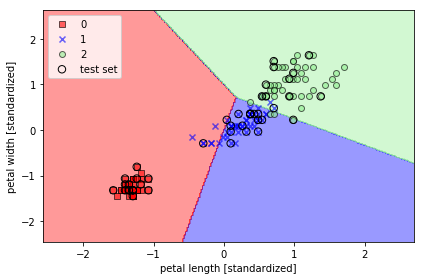

In [9]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/iris_perceptron_scikit.png', dpi=300)
plt.show()

<br>
<br>

# Modeling class probabilities via logistic regression

...

### Logistic regression intuition and conditional probabilities

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def sigmoid(z):
    #exp函数可计算每个数组元素的指数
    return 1.0 / (1.0 + np.exp(-z))

# 建立 list, 由 -7 ~ 7, 每次增加 0.1(所以最大到 6.9 而已)
z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

# 畫圖 x = z, y = phi_z
plt.plot(z, phi_z)
# 畫平均線  axvline 為垂直線， avhline 為水平線
plt.axvline(0.0, color='k')
#設定 y 軸的上下限
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
# 获得子图的对象
ax = plt.gca()
# 加上垂直隔線
ax.yaxis.grid(True)
# 加上水平隔線
ax.xaxis.grid(True)
# 自动调整subplot间的参数，本例中無影響
plt.tight_layout()
# plt.savefig('./figures/sigmoid.png', dpi=300)
plt.show()

In [ ]:
Image(filename='./images/03_03.png', width=500) 

<br>
<br>

### Learning the weights of the logistic cost function

In [ ]:
def cost_1(z):
    return - np.log(sigmoid(z))


def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/log_cost.png', dpi=300)
plt.show()

<br>
<br>

### Training a logistic regression model with scikit-learn

In [ ]:
from sklearn.linear_model import LogisticRegression
# C指定正则化强度，即对参数向量中元素的惩罚力度
# 设置random_state(not None), 相当于设置随机数种子，每次运行随机抽样的结果相同
lr = LogisticRegression(C=1000.0, random_state=1)
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/logistic_regression.png', dpi=300)
plt.show()

In [ ]:
# predict 印出推測的類別
# print(lr.predict(X_test_std))

# predict_proba看出各類別對應的機率，印出結果[第一類別機率, 第二類別機率, ..., 第n類別機率], [第一類別機率, 第二類別機率, ..., 第n類別機率]
# print(lr.predict_proba(X_test_std))

# shape 看 array 由外到內的結構
# print (lr.predict_proba(X_test_std).shape)

# reshape 將 array 重新組合
# (-1, 1) 1筆資料只有 1 個 element, 有多少筆資料讓行數電腦來算
# print(lr.predict_proba(X_test_std[0, :]).reshape(-1, 1))
# (1, -1) 整合成一筆資料，裡面有多少 element 電腦來算
# print(lr.predict_proba(X_test_std[0, :]).reshape(1, -1))


if Version(sklearn_version) < '0.17':
    # 只取其第一行
    lr.predict_proba(X_test_std[0, :])
else:
    # 只取第一行，reshape為一行(沒改變結構)，之後丟去計算機率
    lr.predict_proba(X_test_std[0, :].reshape(1, -1))

<br>
<br>

### Tackling overfitting via regularization

In [ ]:
Image(filename='./images/03_06.png', width=700) 

In [ ]:
weights, params = [], []
# 製造 -5 ~ 5 的 array
for c in np.arange(-5., 5.):
    # C 為 10 的 c 次方
    # C 變小，權重係數就會收縮，增加正規化的強度
    lr = LogisticRegression(C=10.**c, random_state=0)
    lr.fit(X_train_std, y_train)
    # coef_ 会返回得到的w1，w2等系数
    # print(lr.coef_)
    # print(lr.coef_[1])

    weights.append(lr.coef_[1])
    params.append(10**c)
#將 weights 變成 np.arrray
weights = np.array(weights)
# print(weights)
plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
# x 軸單位取 log
plt.xscale('log')
# plt.savefig('./figures/regression_path.png', dpi=300)
plt.show()

<br>
<br>

# Maximum margin classification with support vector machines

In [ ]:
Image(filename='./images/03_07.png', width=700) 

## Maximum margin intuition

...

## Dealing with the nonlinearly separable case using slack variables

In [ ]:
Image(filename='./images/03_08.png', width=600) 

In [ ]:
from sklearn.svm import SVC
# C越大，相当于惩罚松弛变量，希望松弛变量接近0，即对误分类的惩罚增大，趋向于对训练集全分对的情况，这样对训练集测试时准确率很高，但泛化能力弱。C值小，对误分类的惩罚减小，允许容错，将他们当成噪声点，泛化能力较强。
svm = SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/support_vector_machine_linear.png', dpi=300)
plt.show()

## Alternative implementations in scikit-learn

<br>
<br>

# Solving non-linear problems using a kernel SVM

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)
print(X_xor[:5, :])
print(np.unique(y_xor))
plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/xor.png', dpi=300)
plt.show()

In [ ]:
Image(filename='./images/03_11.png', width=700) 

<br>
<br>

## Using the kernel trick to find separating hyperplanes in higher dimensional space

In [ ]:
# BF函数：exp(-gamma|u-v|^2)
# random_state 数据洗牌时的种子值，int值
# gamma  ‘rbf’,‘poly’ 和‘sigmoid’的核函数参数。默认是’auto’，则会选择1/n_features
# C SVC的惩罚参数C?默认值是1.0
svm = SVC(kernel='rbf', random_state=0, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/support_vector_machine_rbf_xor.png', dpi=300)
plt.show()

In [ ]:
from sklearn.svm import SVC

# 將原資料集丟進去，會發現分界線變得彎曲
svm = SVC(kernel='rbf', random_state=0, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/support_vector_machine_rbf_iris_1.png', dpi=300)
plt.show()

In [ ]:
# 調高 gamma, 越高會越準，但過高就 over fitting 了
svm = SVC(kernel='rbf', random_state=0, gamma=100.0, C=1.0)
# svm = SVC(kernel='rbf', random_state=0, gamma=10.0, C=1.0)

svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/support_vector_machine_rbf_iris_2.png', dpi=300)
plt.show()

<br>
<br>

# Decision tree learning

In [ ]:
Image(filename='./images/03_15.png', width=500) 

<br>
<br>

## Maximizing information gain - getting the most bang for the buck

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# gini 不純度
def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))

# entropy 熵值
def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                          ['Entropy', 'Entropy (scaled)', 
                           'Gini Impurity', 'Misclassification Error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.tight_layout()
#plt.savefig('./figures/impurity.png', dpi=300, bbox_inches='tight')
plt.show()

<br>
<br>

## Building a decision tree

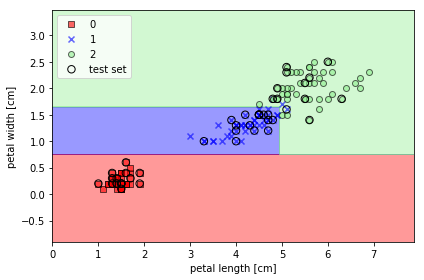

In [11]:
from sklearn.tree import DecisionTreeClassifier

# criterion 衡量分类的质量
# max_depth 表示树的最大深度。如果是"None",则节点会一直扩展直到所有的叶子都是纯的或者所有的叶子节点都包含少于min_samples_split个样本点
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/decision_tree_decision.png', dpi=300)
plt.show()

<br>
<br>

In [12]:
from sklearn.tree import export_graphviz

export_graphviz(tree, 
                out_file='tree.dot', 
                feature_names=['petal length', 'petal width'])

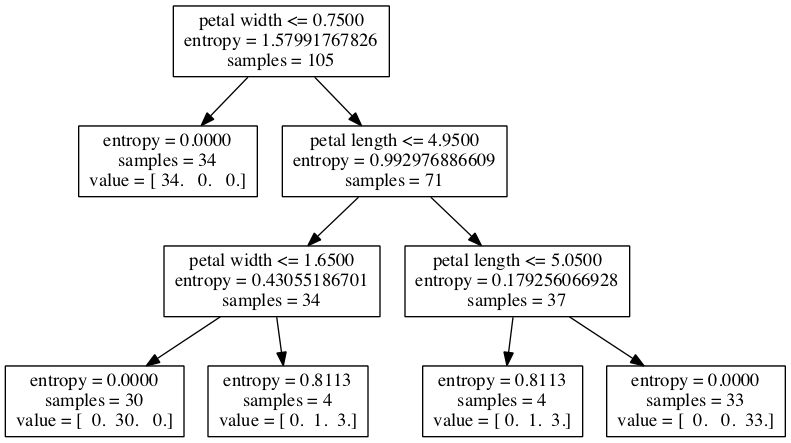

In [13]:
Image(filename='./images/03_18.png', width=600) 

**Note**

If you have scikit-learn 0.18 and pydotplus installed (e.g., you can install it via `pip install pydotplus`), you can also show the decision tree directly without creating a separate dot file as shown below. Also note that `sklearn 0.18` offers a few additional options to make the decision tree visually more appealing.

In [14]:
import pydotplus

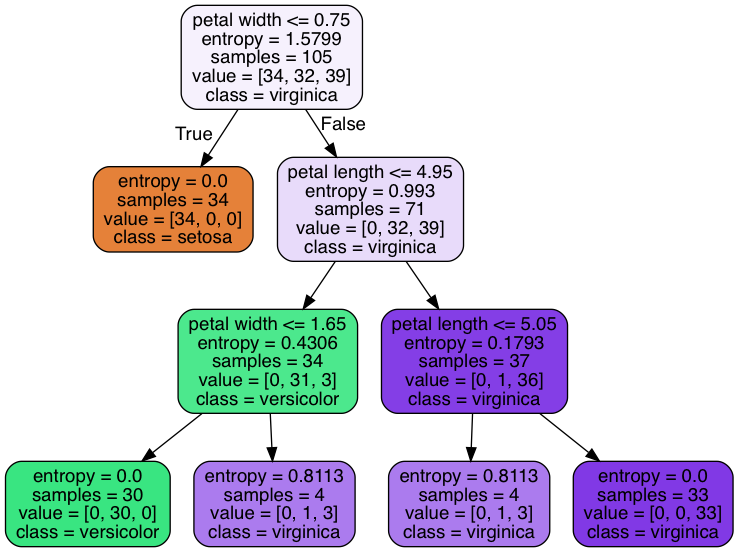

In [15]:
from IPython.display import Image
from IPython.display import display

if Version(sklearn_version) >= '0.18':
    
    try:
        
        import pydotplus
        
        dot_data = export_graphviz(
        tree, 
        out_file=None,
        # the parameters below are new in sklearn 0.18
        feature_names=['petal length', 'petal width'],  
        class_names=['setosa', 'versicolor', 'virginica'],  
        filled=True,
        rounded=True)

        graph = pydotplus.graph_from_dot_data(dot_data)  
        display(Image(graph.create_png()))

    except ImportError:
        print('pydotplus is not installed.')

<br>
<br>

## Combining weak to strong learners via random forests

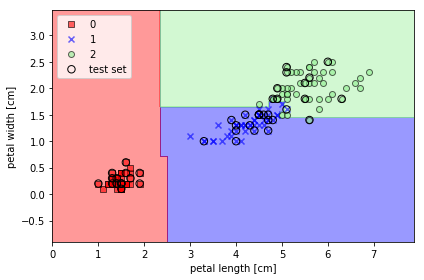

In [22]:
from sklearn.ensemble import RandomForestClassifier

# 决策树的个数，越多越好
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=10, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/random_forest.png', dpi=300)
plt.show()

<br>
<br>

# K-nearest neighbors - a lazy learning algorithm

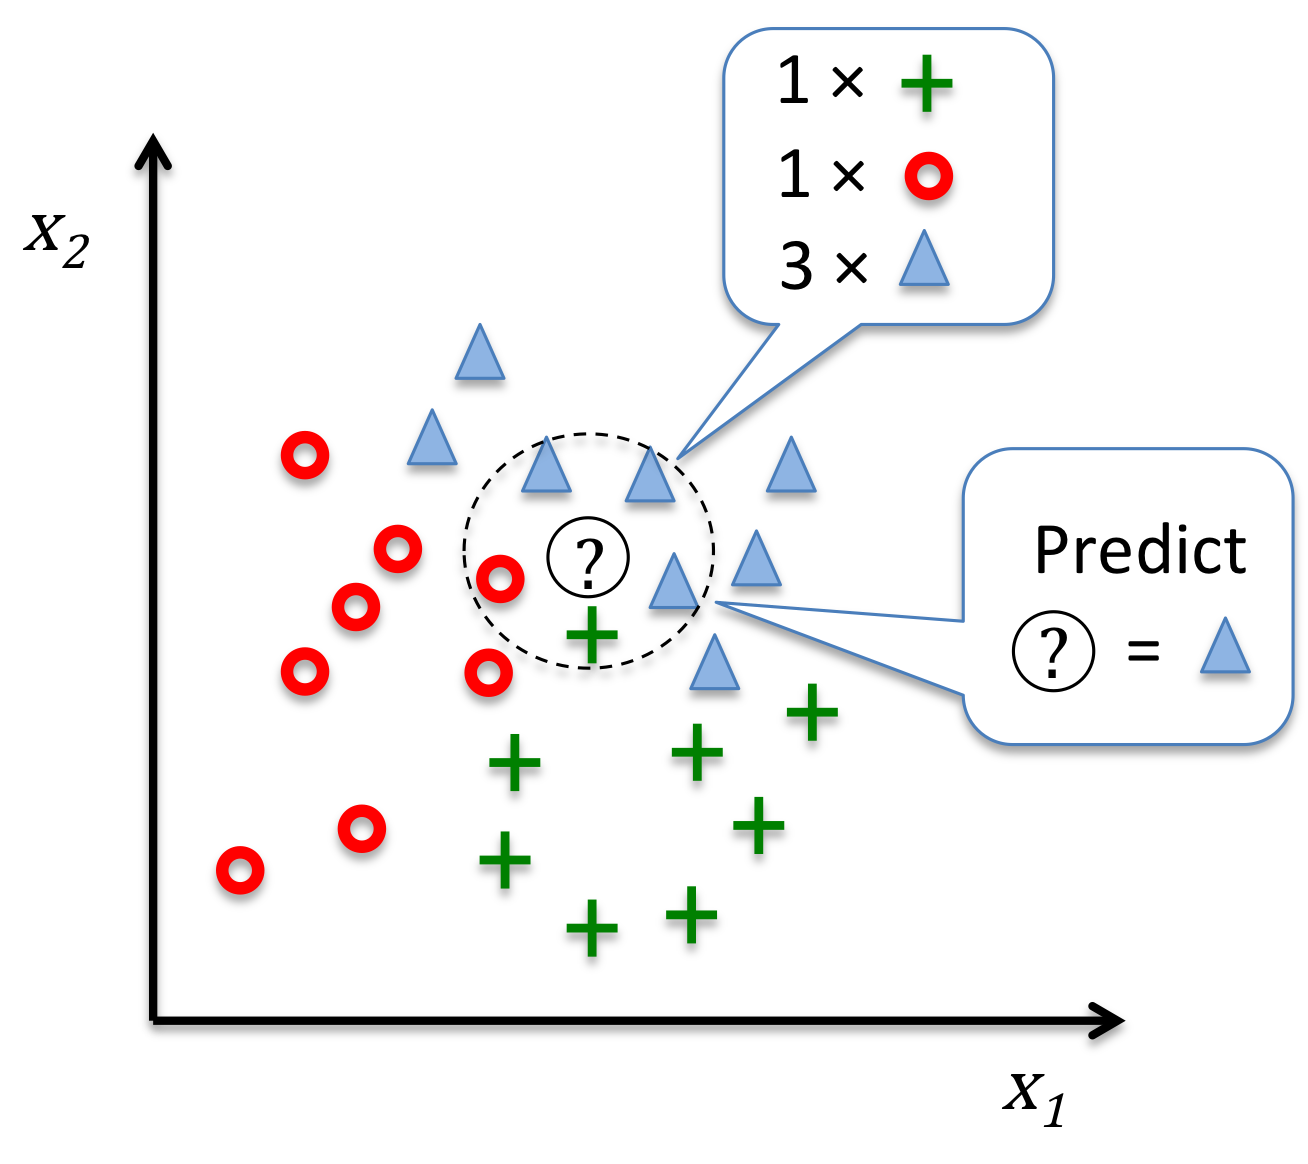

In [23]:
Image(filename='./images/03_20.png', width=400) 

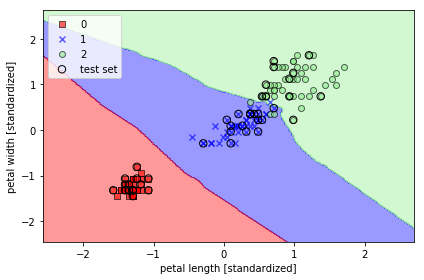

In [29]:
from sklearn.neighbors import KNeighborsClassifier

# 表示查询k个最近邻的数目
# algorithm='auto',指定用于计算最近邻的算法，auto表示试图采用最适合的算法计算最近邻
# K近邻法和限定半径最近邻法类可以使用的距离度量较多，一般来说默认的欧式距离（即 p=2 的闵可夫斯基 minkowski 距离）就可以满足我们的需求
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski', algorithm='auto')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/k_nearest_neighbors.png', dpi=300)
plt.show()

<br>
<br>

# Summary

...